In [1]:
# Librerias:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn import linear_model

import matplotlib.pyplot as plt

In [2]:
# Guardar los datos en variables:
x_data = pd.read_csv('C:/Users/Diego/OneDrive - Universidad Rey Juan Carlos/Documentos/GIA_URJC/Curso 2023-24/G.-IA/Curso_2/Cuatri_2/AprendizajeAutomatico_1/Practicas/Practica_1/Datos/trainX_reto1.csv', sep=';', decimal='.', index_col=0, na_values='?')
y_data = pd.read_csv('C:/Users/Diego/OneDrive - Universidad Rey Juan Carlos/Documentos/GIA_URJC/Curso 2023-24/G.-IA/Curso_2/Cuatri_2/AprendizajeAutomatico_1/Practicas/Practica_1/Datos/trainY_reto1.csv', sep=';', decimal='.', index_col=0, na_values='?')

In [3]:
# Separación en train y test:
random_state = 15
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(y_data, test_size=0.2, random_state=random_state)

# Ordenar los df por id:
x_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

In [4]:
# Guarda x_test en un archivo CSV
x_test.to_csv('x_test.csv', index=True)

# Guarda y_test en otro archivo CSV
y_test.to_csv('y_test.csv', index=True)

In [5]:
# Exploración de datos:
print(x_train.info())
print(x_train.describe())
print('\nModas:\n', x_train.mode(axis=0, dropna=False))
N_x, D_x = x_train.shape

print('\n\n', y_train.info())
print(y_train.describe())
N_y, D_y = y_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 1 to 399
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     249 non-null    float64
 1   bp      250 non-null    float64
 2   sg      228 non-null    float64
 3   al      230 non-null    float64
 4   su      229 non-null    float64
 5   rbc     156 non-null    object 
 6   pc      218 non-null    object 
 7   pcc     255 non-null    object 
 8   ba      255 non-null    object 
 9   bgr     225 non-null    float64
 10  bu      243 non-null    float64
 11  sc      244 non-null    float64
 12  sod     199 non-null    float64
 13  pot     198 non-null    float64
 14  hemo    225 non-null    float64
 15  pcv     209 non-null    float64
 16  wbcc    188 non-null    float64
 17  rbcc    167 non-null    float64
 18  htn     254 non-null    object 
 19  dm      254 non-null    object 
 20  cad     254 non-null    object 
 21  appet   255 non-null    object 
 22  pe

In [6]:
#-- CODIFICACIÓN DE LOS DATOS --#

# Creas una copia del DataFrame original:
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

def encode_col(df):
    le = LabelEncoder()  # Inicializa un LabelEncoder
    encoding_dict = {}  # Inicializa un diccionario para guardar los mapeos

    # Itera sobre cada columna en el DataFrame
    for col in df.columns:
        if df[col].dtype == 'object':  # Verifica si la columna es de tipo 'object'
            non_nan_values = df[col].dropna()  # Elimina los valores NaN de la columna
            if non_nan_values.empty:
                continue  # Si no hay valores no nulos en la columna, continúa con la siguiente columna
            df[col] = df[col].map(lambda x: le.fit(non_nan_values).transform([x])[0] if pd.notnull(x) else np.nan)  # Ajusta el LabelEncoder y transforma la columna
            encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Guarda el mapeo de la columna en el diccionario
    
    return df, encoding_dict


x_train_df, encoding_dict_x = encode_col(x_train_copy)
y_train_df, encoding_dict_y = encode_col(y_train_copy)

print('Dicc. encoding_dict_x: ', encoding_dict_x)
print('Dicc. encoding_dict_y: ', encoding_dict_y)

Dicc. encoding_dict_x:  {'rbc': {'abnormal': 0, 'normal': 1}, 'pc': {'abnormal': 0, 'normal': 1}, 'pcc': {'notpresent': 0, 'present': 1}, 'ba': {'notpresent': 0, 'present': 1}, 'htn': {'no': 0, 'yes': 1}, 'dm': {'no': 0, 'yes': 1}, 'cad': {'no': 0, 'yes': 1}, 'appet': {'good': 0, 'poor': 1}, 'pe': {'no': 0, 'yes': 1}, 'ane': {'no': 0, 'yes': 1}}
Dicc. encoding_dict_y:  {'class': {'ckd': 0, 'notckd': 1}}


In [7]:
# Convierte los valores de los diccionarios a tipos de datos nativos
encoding_dict_x_serializable = {col: {str(k): int(v) for k, v in mapping.items()} for col, mapping in encoding_dict_x.items()}
encoding_dict_y_serializable = {col: {str(k): int(v) for k, v in mapping.items()} for col, mapping in encoding_dict_y.items()}

# Guarda encoding_dict_x en un archivo JSON
with open('encoding_dict_x.json', 'w') as file:
    json.dump(encoding_dict_x_serializable, file)

# Guarda encoding_dict_y en otro archivo JSON
with open('encoding_dict_y.json', 'w') as file:
    json.dump(encoding_dict_y_serializable, file)

In [8]:
# Visualización de valores NaN:
missig_data = x_train_df.isna()

missing_values_column = missig_data.sum(axis=0)
missing_values_row = missig_data.sum(axis=1)

mask_mayorq0 = missing_values_column > 0
mask_mayorq1 = missing_values_row > 0

print(f'Columnas con valores nulos:\n{missing_values_column[mask_mayorq0]}\n')
print(f'Filas con valores nulos:\n{missing_values_row[mask_mayorq1]}\n')

missing_count_row = missing_values_row.value_counts().sort_index()
print(f'Valores NaN en cada fila:\n{missing_count_row}')
missing_count_col = missing_values_column.value_counts().sort_index()
print(f'Valores NaN en cada columna:\n{missing_count_col}')

Columnas con valores nulos:
age        7
bp         6
sg        28
al        26
su        27
rbc      100
pc        38
pcc        1
ba         1
bgr       31
bu        13
sc        12
sod       57
pot       58
hemo      31
pcv       47
wbcc      68
rbcc      89
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

Filas con valores nulos:
1      5
2      3
4      2
6      3
7      3
      ..
349    2
350    2
365    2
378    2
381    2
Length: 156, dtype: int64

Valores NaN en cada fila:
0     100
1      31
2      25
3      20
4      21
5      20
6       5
7      12
8       4
9       8
10      4
11      6
dtype: int64
Valores NaN en cada columna:
1      5
2      3
6      1
7      1
12     1
13     1
26     1
27     1
28     1
31     2
38     1
47     1
57     1
58     1
68     1
89     1
100    1
dtype: int64


In [9]:
# Crear columna dummies valores NaN
for col in x_train_df.columns:
    x_train_df[col + '_isna'] = x_train_df[col].isna().astype(int)

# Sustitución de valores NaN por valor 'mean' columnas 'rbc':
mean_rbc = x_train_df['rbc'].mean()
x_train_df['rbc'].fillna(mean_rbc, inplace=True)

In [10]:
#-- IMPUTACIÓN MULTIVARIANTE --#

# Creas una copia del DataFrame original:
x_train_df_copy = x_train_df.copy()

# Imputación multivariante de los datos NaN:
imputer = IterativeImputer()
train_imputed = imputer.fit_transform(x_train_df_copy)
x_train_df = pd.DataFrame(train_imputed, columns=x_train_df_copy.columns)              # Convertir de nuevo a DataFrame
print(x_train_df.isna().sum())   
print('\nTamaño x_train_df: ', x_train_df.shape)

age           0
bp            0
sg            0
al            0
su            0
rbc           0
pc            0
pcc           0
ba            0
bgr           0
bu            0
sc            0
sod           0
pot           0
hemo          0
pcv           0
wbcc          0
rbcc          0
htn           0
dm            0
cad           0
appet         0
pe            0
ane           0
age_isna      0
bp_isna       0
sg_isna       0
al_isna       0
su_isna       0
rbc_isna      0
pc_isna       0
pcc_isna      0
ba_isna       0
bgr_isna      0
bu_isna       0
sc_isna       0
sod_isna      0
pot_isna      0
hemo_isna     0
pcv_isna      0
wbcc_isna     0
rbcc_isna     0
htn_isna      0
dm_isna       0
cad_isna      0
appet_isna    0
pe_isna       0
ane_isna      0
dtype: int64

Tamaño x_train_df:  (256, 48)


In [11]:
# Guarda el objeto imputer en un archivo pickle
with open('imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)

In [12]:
# Aumento de dimensionalidad:
degree = 2
interaction_only = True

polyf = PolynomialFeatures(degree=degree, interaction_only=interaction_only)
polyf.set_output(transform="pandas")

x_train_dim = polyf.fit_transform(x_train_df)
print('Tamaño x_train_dim: ',x_train_dim.shape)

Tamaño x_train_dim:  (256, 1177)


In [13]:
# Guardamos polyf en un archivo pickle para usarlo en el programa de test:
with open('polyf.pkl', 'wb') as file:
    pickle.dump(polyf, file)

In [14]:
#-- Escalados a intervalos diferentes --#

# Escalado a intervalo unidad [0,1]:
scalerUnit = MinMaxScaler()
x_train_dim_unit = scalerUnit.fit_transform(x_train_dim)

# Escalado al máx. de los valores abs.:
scalerMaxAbs = MaxAbsScaler()
x_train_dim_MaxAbs = scalerMaxAbs.fit_transform(x_train_dim)

# Estandarizamos:
scalerStd = StandardScaler()
x_train_dim_std = scalerStd.fit_transform(x_train_dim)

In [15]:
# Guarda scalerUnit en un archivo pickle
with open('scalerUnit.pkl', 'wb') as file:
    pickle.dump(scalerUnit, file)

# Guarda scalerMaxAbs en otro archivo pickle
with open('scalerMaxAbs.pkl', 'wb') as file:
    pickle.dump(scalerMaxAbs, file)

# Guarda scalerStd en otro archivo pickle
with open('scalerStd.pkl', 'wb') as file:
    pickle.dump(scalerStd, file)

In [16]:
#-- FILTRADO --#

# Filtrado por varianza:
selector_var = VarianceThreshold()
selector_var.set_output(transform="pandas")

x_train_unit_var = selector_var.fit_transform(x_train_dim_unit)
x_train_MaxAbs_var = selector_var.fit_transform(x_train_dim_MaxAbs)
x_train_sdt_var = selector_var.fit_transform(x_train_dim_std)

# Filtrado por correlación:

def drop_highly_correlated_columns(df):
    df = pd.DataFrame(df)   # Crea un DataFrame de pandas
    df_corr = df.corr().abs()  # Calculas la matriz de correlación
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))    # Seleccionas el triángulo superior de la matriz de correlación
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]  # Encuentras las columnas con correlación mayor a 0.9 (puedes ajustar este valor a tus necesidades)    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    col_dropped = list(to_drop) # Guarda la lista de columnas eliminadas
    df_ret = df.drop(col_dropped, axis=1)    # Eliminas las columnas altamente correlacionadas
    return df_ret, col_dropped

x_train_corr, col_drop_corr = drop_highly_correlated_columns(x_train_dim)
x_train_unit_corr, col_drop_unit = drop_highly_correlated_columns(x_train_dim_unit)
x_train_MaxAbs_corr, col_drop_MaxAbs = drop_highly_correlated_columns(x_train_dim_MaxAbs)
x_train_std_corr, col_drop_std = drop_highly_correlated_columns(x_train_dim_std)

In [17]:
# Guarda selector_var en un archivo pickle
with open('selector_var.pkl', 'wb') as file:
    pickle.dump(selector_var, file)

# Guarda las listas de columnas eliminadas en archivos pickle
with open('col_drop_corr.pkl', 'wb') as file:
    pickle.dump(col_drop_corr, file)

with open('col_drop_unit.pkl', 'wb') as file:
    pickle.dump(col_drop_unit, file)

with open('col_drop_MaxAbs.pkl', 'wb') as file:
    pickle.dump(col_drop_MaxAbs, file)

with open('col_drop_std.pkl', 'wb') as file:
    pickle.dump(col_drop_std, file)

In [18]:
#-- ENTRENAMOS LOS MODELOS LINEALES --#
reg_model_unit = linear_model.LinearRegression()
reg_model_unit.fit(x_train_unit_var, y_train_df['class'])

reg_model_MaxAbs = linear_model.LinearRegression()
reg_model_MaxAbs.fit(x_train_MaxAbs_var, y_train_df['class'])

reg_model_std = linear_model.LinearRegression()
reg_model_std.fit(x_train_sdt_var, y_train_df['class'])

reg_model_corr = linear_model.LinearRegression()
reg_model_corr.fit(x_train_corr, y_train_df['class'])

reg_model_unit_corr = linear_model.LinearRegression()
reg_model_unit_corr.fit(x_train_unit_corr, y_train_df['class'])

reg_model_MaxAbs_corr = linear_model.LinearRegression()
reg_model_MaxAbs_corr.fit(x_train_MaxAbs_corr, y_train_df['class'])

reg_model_std_corr = linear_model.LinearRegression()
reg_model_std_corr.fit(x_train_std_corr, y_train_df['class'])

LinearRegression()

In [19]:
# Guardar los modelos en archivos pickle
with open('reg_model_unit.pkl', 'wb') as file:
    pickle.dump(reg_model_unit, file)

with open('reg_model_MaxAbs.pkl', 'wb') as file:
    pickle.dump(reg_model_MaxAbs, file)

with open('reg_model_std.pkl', 'wb') as file:
    pickle.dump(reg_model_std, file)

with open('reg_model_corr.pkl', 'wb') as file:
    pickle.dump(reg_model_corr, file)

with open('reg_model_unit_corr.pkl', 'wb') as file:
    pickle.dump(reg_model_unit_corr, file)

with open('reg_model_MaxAbs_corr.pkl', 'wb') as file:
    pickle.dump(reg_model_MaxAbs_corr, file)

with open('reg_model_std_corr.pkl', 'wb') as file:
    pickle.dump(reg_model_std_corr, file)

Tamaño del DataFrame original:  (256, 48)
Tamaño del nuevo DataFrame:  (256, 23) 

Tabla con los componentes principales hasta explicar el 90.0% de la varianza


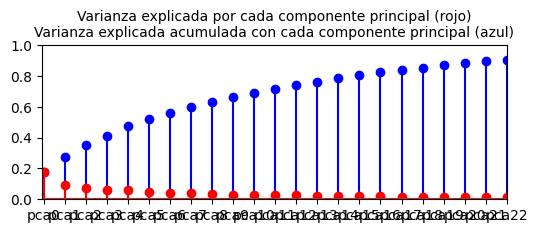

LinearRegression()

In [20]:
#-- PCA --#

# Estandarizamos primero:
print('Tamaño del DataFrame original: ', x_train_df.shape)
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(x_train_df)
x_train_df_std = scaler.transform(x_train_df)

# PCA seleccionando diréctamente el número de componentes o un porcentaje de información que queremos mantener:
n_components = 0.90 # si se pone un núm. entero (3) sería el núm. de columnas que mantendríamos

pca = PCA(n_components= n_components).set_output(transform='pandas')
pca.fit(x_train_df_std)
x_train_pca = pca.transform(x_train_df_std)

print('Tamaño del nuevo DataFrame: ', x_train_pca.shape, f'\n\nTabla con los componentes principales hasta explicar el {n_components*100}% de la varianza')

# Visualización del peso de cada columna calculada:
def plot_PCA(pca):
  plt.stem(pca.explained_variance_ratio_.cumsum(),'b')
  plt.stem(pca.explained_variance_ratio_,'r')

  titleStr = 'Varianza explicada por cada componente principal (rojo)'
  titleStr = titleStr+'\n'
  titleStr = titleStr+'Varianza explicada acumulada con cada componente principal (azul)'
  plt.title(titleStr, fontsize=10)
  ax = plt.gca()
  ax.axis([-0.1,1.1,0,1])
  ax.set_xticks([i for i in range(pca.n_components_)])
  ax.set_xticklabels(["pca"+str(i) for i in range(pca.n_components_)])

  fig = plt.gcf()
  fig.set_size_inches(6,2)

  plt.show()

plot_PCA(pca)

# Entrenamos el modelo con X_train_var_filtered:
reg_model_pca = linear_model.LinearRegression()
reg_model_pca.fit(x_train_pca, y_train_df['class'])

In [21]:
# Guardar los objetos de PCA en archivos pickle:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

with open('reg_model_pca.pkl', 'wb') as file:
    pickle.dump(reg_model_pca, file)